# BCI homework

# Brain-Computer Interfaces (Fall 2017, ELE 594)
# Instructor: Yalda Shahriari

# 1st homework, 9/23/17 (The homework, is due by Oct 4, 11:55 pm).

# Instruction: 
Load the “sampleEEGdata” into your Matlab workspace. 
This EEG dataset contains 64 channels (EEG.nbchan), 640 time points (EEG.pnts), and 99 trials (EEG.trials). 
The time points in ms has been saved in EEG.times where you can see each trial has been started 
from -1000 ms and ends at ~1500 ms. 
Use the topoplot.m function for plotting the head plots. 
Save the ‘eloc64C2.txt’ file in the same directory as the topoplot.m function for further analysis. 

In [1]:
# Here are the functions, 
# which reconstructs the dictionaries just use this loadmat instead of scipy.io's loadmat:

import scipy.io as spio
import numpy as np

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

def _check_keys(dict):
    '''
    checks if entries in dictionary are mat-objects. If yes
    todict is called to change them to nested dictionaries
    '''
    for key in dict:
        if isinstance(dict[key], spio.matlab.mio5_params.mat_struct):
            dict[key] = _todict(dict[key])
    return dict        

def _todict(matobj):
    '''
    A recursive function which constructs from matobjects nested dictionaries
    '''
    dict = {}
    for strg in matobj._fieldnames:
        elem = matobj.__dict__[strg]
        if isinstance(elem, spio.matlab.mio5_params.mat_struct):
            dict[strg] = _todict(elem)
        else:
            dict[strg] = elem
    return dict

In [2]:
# Load the “sampleEEGdata” into your Matlab workspace. 
data = loadmat(filename='sampleEEGdata')
data['EEG'].keys()

dict_keys(['chanlocs', 'xmax', 'icasplinefile', 'reject', 'specdata', 'epoch', 'icaweights', 'data', 'urevent', 'session', 'icawinv', 'specicaact', 'times', 'dipfit', 'pnts', 'icaact', 'comments', 'saved', 'chaninfo', 'group', 'eventdescription', 'stats', 'xmin', 'etc', 'epochdescription', 'spedata', 'splinefile', 'event', 'icachansind', 'urchanlocs', 'condition', 'history', 'trials', 'filepath', 'ref', 'nbchan', 'setname', 'filename', 'icasphere', 'subject', 'srate'])

In [3]:
# This EEG dataset contains 64 channels (EEG.nbchan), 640 time points (EEG.pnts), and 99 trials (EEG.trials). 
eeg = data['EEG']
eeg['nbchan'], eeg['pnts'], eeg['trials']
# _todict(eeg['chanlocs'][0])

(64, 640, 99)

In [4]:
# The time points in ms has been saved in EEG.times where you can see each trial has been started 
# from -1000 ms and ends at ~1500 ms.
eeg['times'].shape
t_start = -1000 # ms: milisecond
t_end = 1500 # ms
t_duration = t_end - t_start
sfreq = (eeg['times'].shape[0]/t_duration) * 1000
sfreq, eeg['srate']

(256.0, 256)

In [56]:
# Use the topoplot.m function for plotting the head plots.
# Creating mne Objects from numpy arrays
import mne as mne

labels = []
XYZs = []
for each in eeg['chanlocs']:
    label = _todict(matobj=each)['labels']
    labels.append(label)
    X = _todict(matobj=each)['X']
    Y = _todict(matobj=each)['Y']
    Z = _todict(matobj=each)['Z']
    XYZs.append(np.array([X, Y, Z], dtype=float))
    
# len(labels)
XYZs = np.array(XYZs, dtype=float)
XYZs
ch_names = labels #mat['ch_names'].tolist()
elec = XYZs #mat['elec']
dig_ch_pos = dict(zip(ch_names, elec))
mon = mne.channels.DigMontage(dig_ch_pos=dig_ch_pos)

# It is also possible to use info from another raw object.
info = mne.create_info(ch_names=ch_names, ch_types='eeg', montage=mon, sfreq=eeg['srate'])

data = eeg['data'].transpose(2, 0, 1)
data.shape  # data : array, shape (n_epochs, n_channels, n_times)

events, events_id = [], []
for epoch in eeg['epoch']:
    epoch = _todict(epoch)
    event_num = epoch['event'][1]
    event_id_prev = epoch['eventtype'][0] # previous event id
    event_id = epoch['eventtype'][1] # event id
    event = np.array([event_num, event_id_prev, event_id], dtype=int)
    events.append(event)
    events_id.append(event_id)

events = np.array(events, dtype=int)
events.shape
# events

# # if len(np.unique(events[:, 0])) != len(events):
# #     print('wrong')
# np.unique(events[:, 0]), len(np.unique(events[:, 0])), len(events)

epochs = mne.EpochsArray(data=data, events=events, event_id=events_id, info=info, tmin=eeg['xmin'])
picks = mne.pick_types(info=info, meg=False, eeg=True, misc=False)
evoked = epochs.average()

99 matching events found
0 projection items activated
0 bad epochs dropped


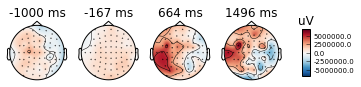

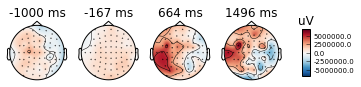

In [75]:
# epochs.plot
# epochs.plot(picks=picks, scalings='auto', show=True, block=True, events=events)
# epochs.plot_drop_log()
# epochs.plot_image(picks=picks)
# epochs.plot_projs_topomap()
# epochs.plot_psd(picks=picks, tmin=eeg['xmin'], tmax=eeg['xmax'], show=True)
# epochs.plot_psd_topomap()
# epochs.plot_sensors()
# epochs.plot_topo_image()

# evoked.plot(picks=picks)
# evoked.plot_field()
# evoked.plot_image(picks=picks, show='True')

# ts_args = dict(gfp=True)
# topomap_args = dict(sensors=False)
# # evoked_r_aud.plot_joint(title='right auditory', times=[.07, .105],
# #                         ts_args=ts_args, topomap_args=topomap_args)
# evoked.plot_joint(exclude=(), picks=picks, show='True', topomap_args=topomap_args, ts_args=ts_args)
# evoked.plot_joint()

# evoked.plot_topomap()
# evoked.animate_topomap()
# evoked.plot_projs_topomap()
# evoked.plot_sensors()
# evoked.plot_topo()
evoked.plot_topomap()
# evoked.plot_white()

In [76]:
# Save the ‘eloc64C2.txt’ file in the same directory as the topoplot.m function for further analysis.
% ls

bci-hw1-Copy1.ipynb       eloc64C2.txt*  README
bci-hw1.ipynb             HW1.pdf        sampleEEGdata.mat*
Channel Description.txt*  mne_examples/  topoplot.m*


# 1-

In [95]:
# a) Extract epochs from 0 to 800 ms.
# eeg['xmin'], eeg['xmax']
# epochs = mne.EpochsArray(data=data, event_id=events_id, events=events, info=info, reject_tmin=0.0, 
#                          reject_tmax=0.8, tmin=eeg['xmin'])
# epochs = mne.EpochsArray(data=data, event_id=events_id, events=events, info=info, baseline=(0.0, 0.8))
# epochs

raw = mne.io.RawArray(data=data[0], info=info)
epochs = mne.Epochs(add_eeg_ref=eeg['ref'], data=data, baseline=(0.0, 0.8), event_id=events_id, info=info, 
                    events=events)

# Compute the ERPs at each electrode. 

# Get the average over all the trials. 

# Select nine time points at which to show topographical plots (e.g., 0 to 800 ms in 100- ms steps). 

# In one figure, make a series of topographical plots at these time points. 

# To increase the signal-to-noise ratio (SNR), make each plot show the average of activity from 20 ms before 
# until 20 ms after each time point. 

# For example, the topographical plot from 200 ms should show average activity from 180 ms until 220 ms. 

# Indicate the center time point in a title on each subplot.

99 matching events found
0 projection items activated
0 bad epochs dropped


<EpochsArray  |  n_events : 99 (all good), tmin : 0.0 (s), tmax : 2.49609375 (s), baseline : (0.0, 0.8), ~31.1 MB, data loaded,
 '1': 38, '31': 61>

In [ ]:
# b) Loop through each electrode and find the peak time of the ERP between 100 and 800 ms.

# Store these peak times in a separate variable and then make a topographical plot of the peak times
# (that is, the topographical map will illustrate times in milliseconds, not activity at peak times).

# Include a color bar in the figure and make sure to show times in milliseconds from time 0 (not, for
# example, time indices instead of milliseconds).

# What areas of the scalp show the earliest and the latest peak responses to the stimulus within this window?

In [133]:
# c) Repeat step (a) by applying large Laplacian filter.

# Compare step (c) with step (a) and clearly explain your observations and comments (hint: To obtain the distance
# and the surrounding electrodes, transfer the polar coordinates in eloc64C2.txt file into Cartesian.
                                                                                   
# Then for each electrode of interest keep those electrodes that are in radius [0.18 0.28], 
# remove the rest, continue obtaining your weights, and then the Laplacian filtered signal). 

In [ ]:
# (Note: Make the colormaps in ‘jet’ format and keep the color limit for all the topoplots and for
# each section the same).

# 2-

In [134]:
# a) Create a family of complex Morlet wavelets, ranging in frequencies from 2 Hz to 30 Hz in five steps. 
# Consider cycle as a fix number of 4 cycle.

In [ ]:
# b) Convolve each wavelet with EEG data from all electrodes and from only first trial 
# (hint: you can get the fft of both data and wavelet; multiply in the frequency domain, 
#  get ifft to return it back to the time domain, 
#  and then in order to make the convolved data the same length as the original data cut out the begging 
#  and the end of the convolved data with the cutting length equivalent to half of the wavelet length). 

In [ ]:
# c) Extract power and phase from the result of the complex wavelet convolution and store in a
# time x frequency x electrodes x power/phase matrix (thus, a 640 x 5 x 64 x 2 matrix).

In [135]:
# d) Make topographical plots of power and phase at 180 ms at all frequencies (hint: you may need
# to use the squeeze function to remove singleton dimensions).

# Arrange the plots in one figure with five columns for frequency and two rows for power/phase. 

# Put labels in the plot so it is clear which topographical maps correspond to which frequencies.

In [ ]:
# e) Repeat step (d) for activity at 360 ms, and 650 ms.

In [136]:
# f) Are there any prominent topographical features in power or in phase? 

# Do these differ for different frequencies? 

# Do power and phase have similar topographical distributions? 

# Is there any reason to suspect that they might have similar or different topographies?

In [ ]:
# g) (Optional) Now consider the frequency range varies between 2Hz to 30Hz in two steps.

# Instead of constant cycle equivalent to 4 (what we had before), 
# consider variable cycles ranging between [3 10] cycle. 

# Based on your total number of frequencies, 
# you can define constant steps for your cycles where it starts from 3 cycles and ends at 10 cycles. 

# 3 would correspond to the minimum frequency (i.e. 2 Hz) and 10 would correspond to the maximum frequency (i.e. 30 Hz).

# Considering only channel ‘FCz’, for each frequency, obtain the power for all the trials (i.e. 99).

# Get the average of the powers over all the trials. 

# Apply baseline correction by dividing the obtained results to the average baseline power (i.e. [-500 -200 ms]). 

# The resulting matrix size would be 20 x 640. 

# Plot the time-frequency map where the x-axis is the time [-200 1000 ms], 
# y-axis is the frequency [2 30 Hz], and color corresponds to 10log10 (power). 

# Make the colormaps in ‘jet’ format and the color-limit to [-3 3]. 

# Repeat the same process with fixed cycle 4 for all the frequencies.

# Compare your results between two conditions of fixed and variable cycles and explain your observations. 